In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from collections import defaultdict
import traceback
import numpy as np
import scipy.stats as ss
import random
import copy
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]
# 
# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
# df = df[df.localization_node != 'localization_generator']
# df = df[(df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
metrics += ['norm_trajectory_length']
metrics_and_versions += ['norm_trajectory_length']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
# if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

In [14]:
SMOOTHING = False

# discretize features
bin_widths_dict = {  # 3x the original
    'amcl_alpha_factor': (None, None),
    'beta_1': (None, None),
    'absolute_translation_error': (0.0, 0.03),
    'absolute_rotation_error': (0.0, 0.003),
    'normalized_relative_translation_error': (0.0, 0.015),
    'normalized_relative_rotation_error': (0.0, 0.015),
    'collisionless_success_rate': (-0.5, 1),
    'collision_rate': (-0.5, 1),
    'norm_trajectory_length': (1.0, 0.015),
    'norm_execution_time': (1.0, 0.015),
    'average_translation_velocity': (0.0, 0.015),
    'average_velocity_atan': (0.0, 0.15),
}
# bin_widths_dict = {  # 3x the original
#     'amcl_alpha_factor': None,
#     'beta_1': None,
#     'absolute_translation_error': 0.03,
#     'absolute_rotation_error': 0.003,
#     'normalized_relative_translation_error': 0.015,
#     'normalized_relative_rotation_error': 0.015,
#     'collisionless_success_rate': None,
#     'collision_rate': None,
#     'norm_trajectory_length': 0.015,
#     'norm_execution_time': 0.015,
#     'average_translation_velocity': 0.015,
#     'average_velocity_atan': 0.15,
# }

bins_dict = dict()
for feature_name, (bin_min, bin_width) in bin_widths_dict.items():
    if bin_width is not None:
        bins = np.arange(bin_min, df[feature_name].max() + bin_width, bin_width)
        bins_dict[feature_name] = bins[:-1]
        df[f'{feature_name}_d'] = pd.cut(df[feature_name], bins, right=False, labels=bins[:-1]).astype('float')
    else:
        df[f'{feature_name}_d'] = df[feature_name]
        bins_dict[feature_name] = sorted(df[feature_name].unique())

def df_to_distribution(output_name, d):

    output_name_d = f"{output_name}_d"
    
    # this is the count of non-NaN values: d[output_name_d].notna().sum()
    if SMOOTHING:
        smoothing_dataseries = pd.Series(data=0.0001, index=bins_dict[output_name])
    else:
        smoothing_dataseries = pd.Series()
    dist = (d.groupby(output_name_d)[output_name_d].count() / d[output_name_d].notna().sum()).add(smoothing_dataseries, fill_value=0.0)
    dist = dist / dist.sum()
    return dist

# def df_to_distribution(output_name, d):
#     output_name_d = f"{output_name}_d"
#     # this is the count of non-NaN values: d[output_name_d].notna().sum()
#     return d.groupby(output_name_d)[output_name_d].count() / d[output_name_d].notna().sum()

def distribution_to_distribution(output_name, input_name, input_distribution, d):
    output_name_d = f"{output_name}_d"
    input_name_d = f"{input_name}_d"

    if 0.0001 < input_distribution.sum() < 0.9999:
        print_warn(f"0.0001 < {input_name} sum [= {input_distribution.sum()}] < 0.9999")

    output_dist = pd.Series()
    for index_i, p_i in zip(input_distribution.index, input_distribution):
        d_i = d[d[input_name_d] == index_i]
        dist_i = df_to_distribution(output_name=output_name, d=d_i)
#         if p_i == 0.0 or dist_i.sum() == 0.0:
#             print_warn(f"p_i == 0.0 or dist_i.sum() == 0.0: index_i = {index_i}, dist_i.sum() = {dist_i.sum()}, p_i = {p_i}")
        output_dist = output_dist.add(dist_i*p_i, fill_value=0)
    
    if not SMOOTHING:
        output_dist = output_dist / output_dist.sum()
    
    if 0.0001 < output_dist.sum() < 0.9999:
        print_warn(f"0.0001 < {output_name} sum [= {output_dist.sum()}] < 0.9999")
    if output_dist.max() > 1.0:
        print_warn(f"{output_name} max [= {output_dist.max()}] > 1.0")
    if output_dist.min() < 0.0:
        print_warn(f"{output_name} min [= {output_dist.min()}] < 0.0")

    return output_dist

def distribution_mean(dist):
    bin_width = np.min(dist.index[1:] - dist.index[:-1])
    bin_centers = dist.index + bin_width/2
    return np.sum(bin_centers * dist.values)

def plot_distribution(output_name, distribution_1, distribution_2=None, label_1=None, label_2=None):
    output_name_d = f"{output_name}_d"
    
    fig = plt.figure()
    
    w_1 = np.min(distribution_1.index[1:].values - distribution_1.index[:-1].values) if len(distribution_1.index) > 1 else 1
    hist = plt.bar(distribution_1.index + w_1/2, distribution_1, w_1, fill=True, label=label_1, color='silver')
    plt.scatter(distribution_mean(distribution_1), -0.03, label=f"{label_1} mean", color='silver')
    
    if distribution_2 is not None:
        w_2 = np.min(distribution_2.index[1:].values - distribution_2.index[:-1].values) if len(distribution_2.index) > 1 else 1
        hist = plt.bar(distribution_2.index + w_2/2, distribution_2, w_2, fill=False, label=label_2, edgecolor='blue')
        plt.scatter(distribution_mean(distribution_2), -0.03, label=f"{label_2} mean", color='blue')
    
    if label_1 is not None or label_2 is not None:
        plt.legend()
    
    plt.xlabel(output_name_d.replace('_', ' '))
    plt.grid()
    fig.set_size_inches([20, 3])
    plt.show()


In [15]:
# dataset splits based on run_index
ri = sorted(df.run_index.unique())
random.Random(0).shuffle(ri)
l = len(ri)
split_localization, split_local_planner, split_ground_truth = ri[0:int(l/3)], ri[int(l/3):int(2*l/3)], ri[int(2*l/3):]
len(split_localization), len(split_local_planner), len(split_ground_truth)

(10, 10, 10)

## localization performance: absolute_translation_error

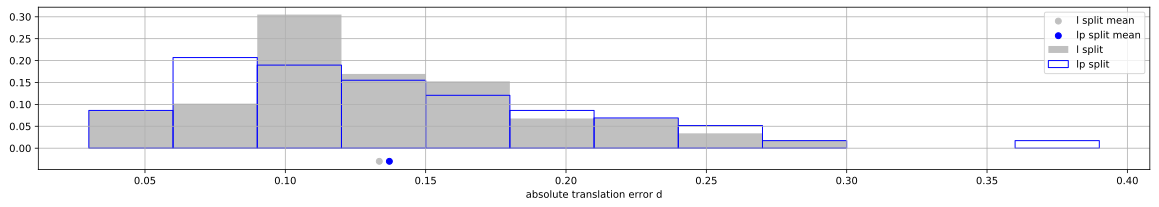

## localization performance: absolute_rotation_error

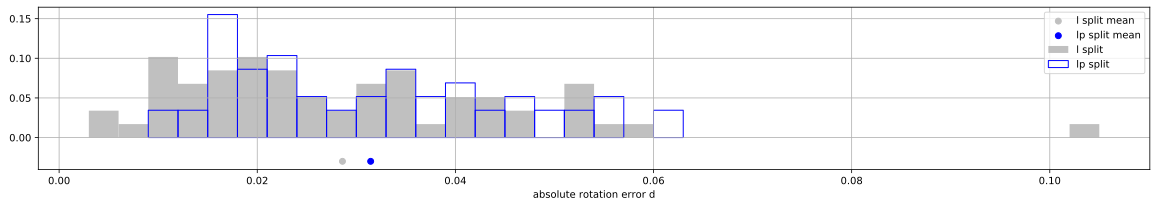

## localization performance: normalized_relative_translation_error

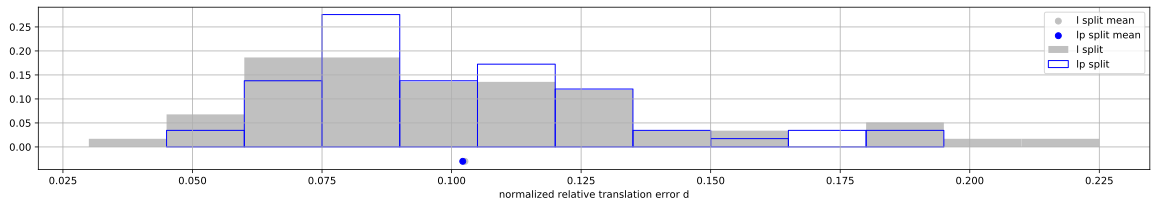

## localization performance: normalized_relative_rotation_error

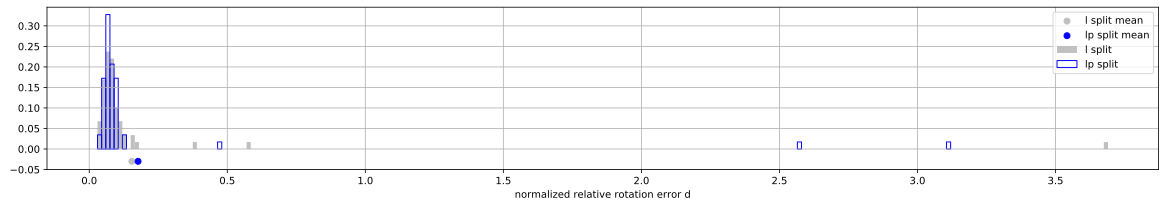

## local planner performance (all): collisionless_success_rate

### from absolute_translation_error

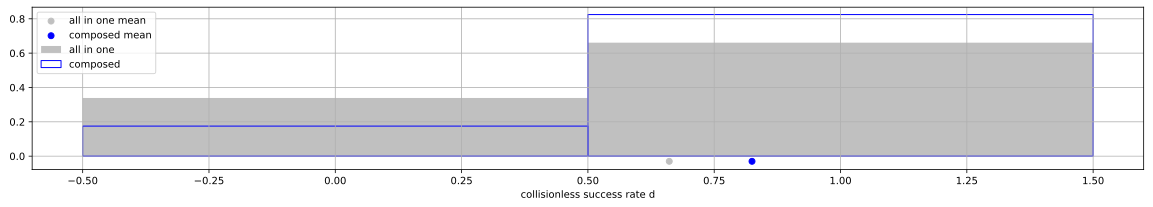

0.6610169491525424 0.8248098417589943


### from absolute_rotation_error

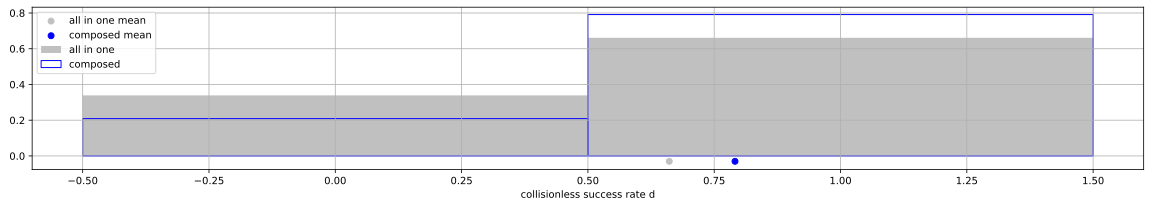

0.6610169491525424 0.7911522633744856


### from normalized_relative_translation_error

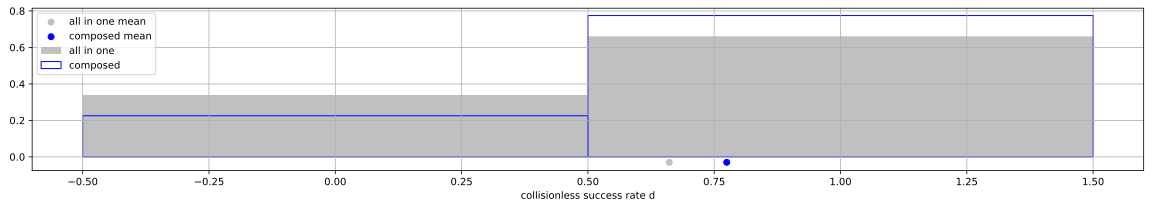

0.6610169491525424 0.7747767857142857


### from normalized_relative_rotation_error

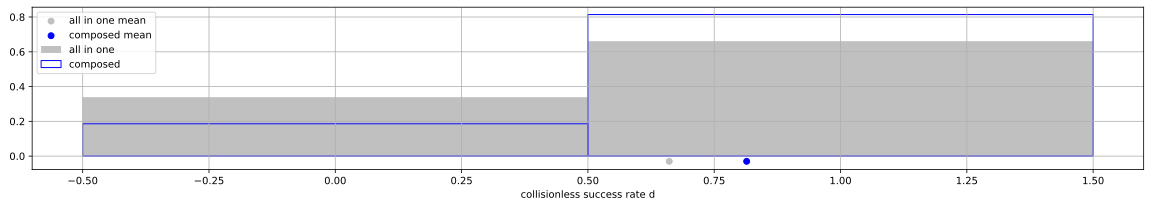

0.6610169491525424 0.8141962047977085


## local planner performance (all): collision_rate

### from absolute_translation_error

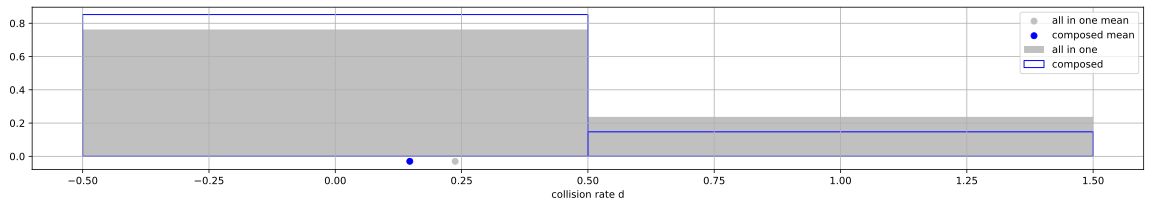

0.23728813559322035 0.14745518135348645


### from absolute_rotation_error

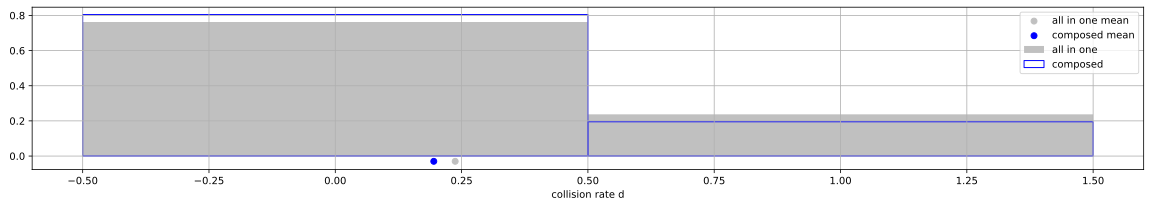

0.23728813559322035 0.19495884773662556


### from normalized_relative_translation_error

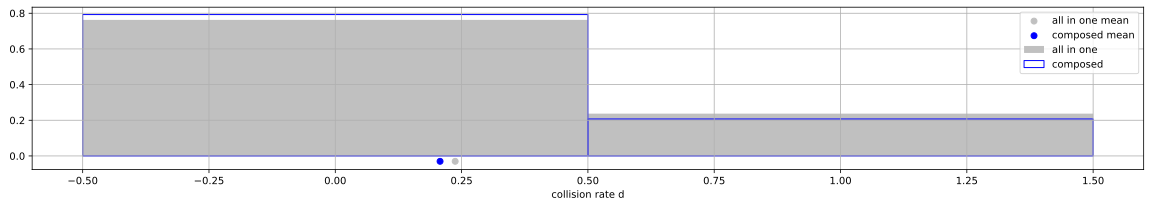

0.23728813559322035 0.20736607142857144


### from normalized_relative_rotation_error

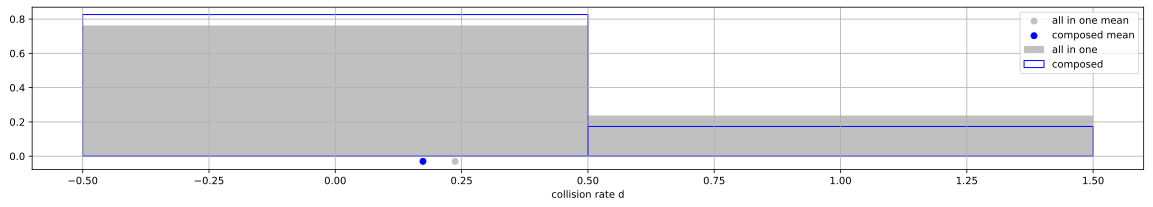

0.23728813559322035 0.17355889724310775


## local planner performance (success): norm_trajectory_length

### from absolute_translation_error

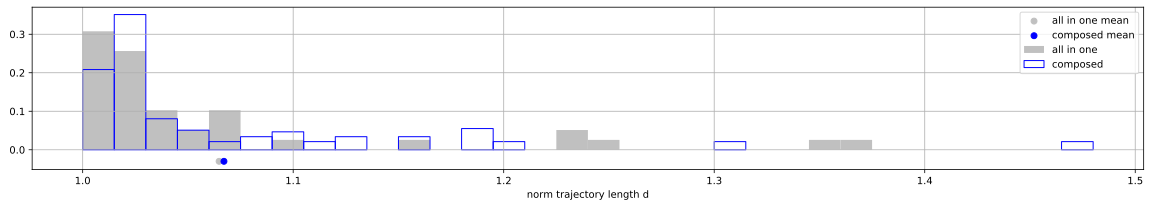

### from absolute_rotation_error

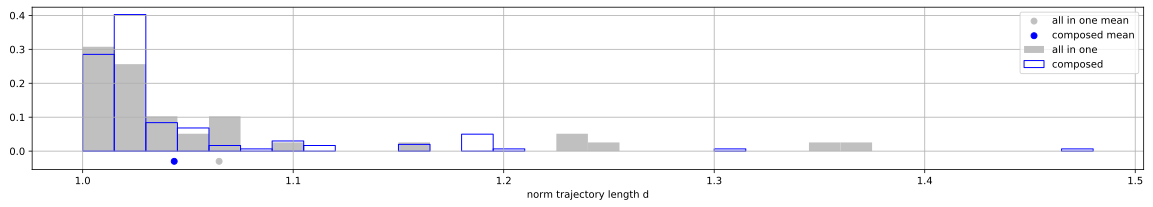

### from normalized_relative_translation_error

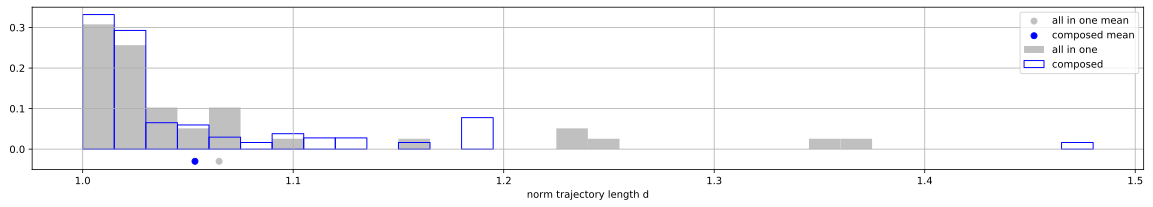

### from normalized_relative_rotation_error

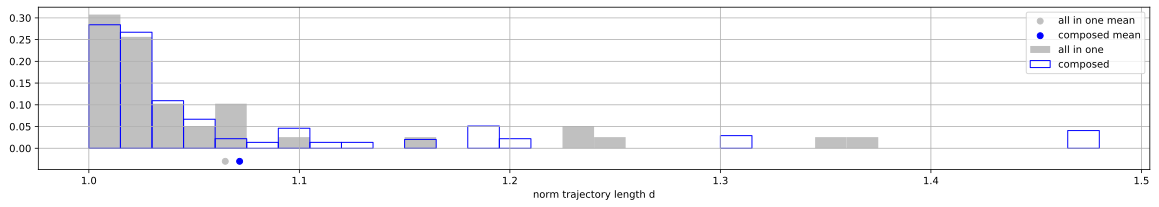

## local planner performance (success): norm_execution_time

### from absolute_translation_error

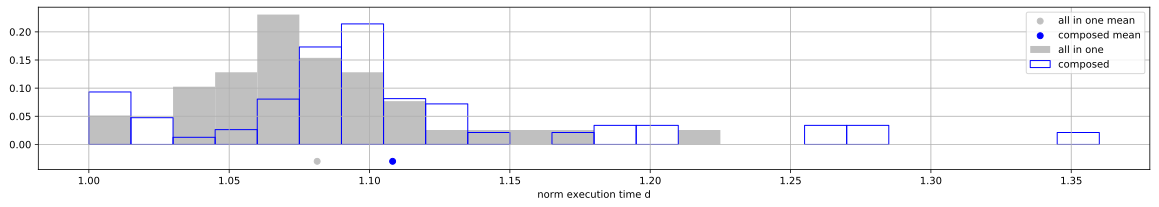

### from absolute_rotation_error

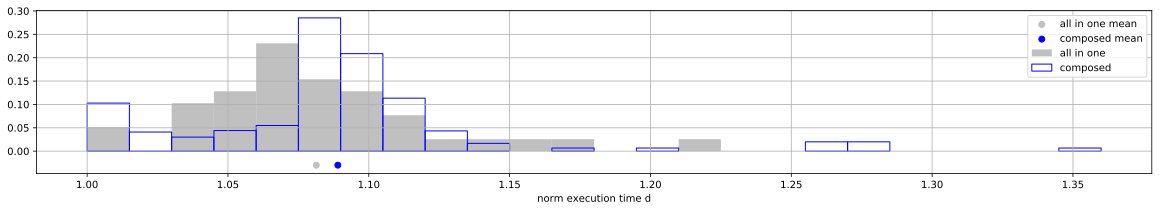

### from normalized_relative_translation_error

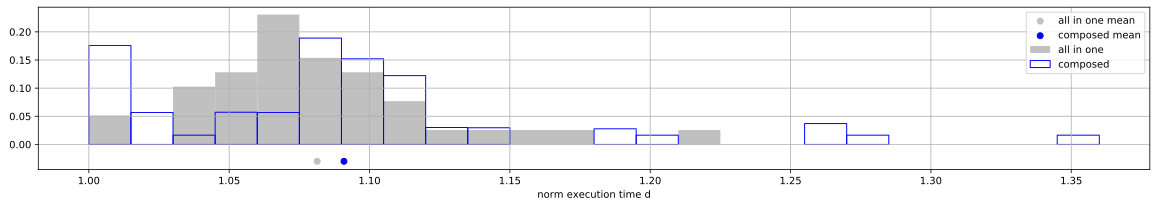

### from normalized_relative_rotation_error

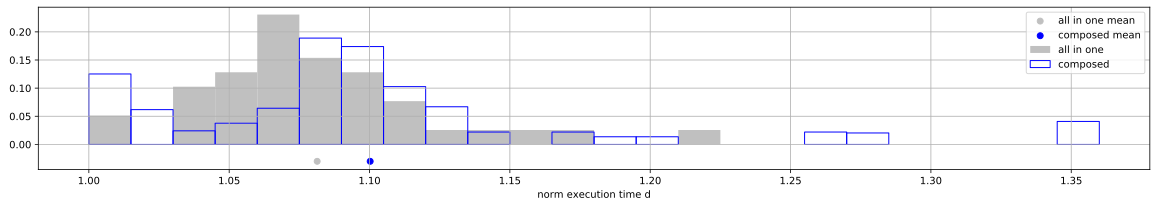

In [16]:

localization_performance = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]
local_planner_performance_all = [
    'collisionless_success_rate',
    'collision_rate',
]
local_planner_performance_success = [
    'norm_trajectory_length',
    'norm_execution_time',
]

amcl_alpha_factor = 1.0
beta_1 = 0.1

d_all = df[
    (df.max_steering_angle_deg == 90.) &
    (df.robot_model == 'turtle') &
    (df.global_planner_node == 'navfn') &
    (df.localization_node == 'amcl')  &
    (df.local_planner_node == 'teb') &
    (df.amcl_alpha_factor == amcl_alpha_factor) &
    (df.beta_1 == beta_1)].copy()
d_success = df[
    (df.collisionless_success_rate == 1) &
    (df.max_steering_angle_deg == 90.) &
    (df.robot_model == 'turtle') &
    (df.global_planner_node == 'navfn') &
    (df.localization_node == 'amcl') &
    (df.local_planner_node == 'teb') &
    (df.amcl_alpha_factor == amcl_alpha_factor) &
    (df.beta_1 == beta_1)].copy()

d_localization = d_all[d_all.run_index.isin(split_localization)]
d_local_planner_all = d_all[d_all.run_index.isin(split_local_planner)]
d_local_planner_success = d_success[d_success.run_index.isin(split_local_planner)]
d_gt_all = d_all[d_all.run_index.isin(split_ground_truth)]
d_gt_success = d_success[d_success.run_index.isin(split_ground_truth)]

dists_loc = dict()
dists_loc_gt = dict()
dists_loc_lp = dict()
# dists_lp_gt = dict()
# local_planner_composed_dists = defaultdict(dict)

for localization_performance_name in localization_performance:
    printmd(f"## localization performance: {localization_performance_name}")
    dists_loc[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_localization)
    dists_loc_lp[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_local_planner_all)
    plot_distribution(
        output_name=localization_performance_name,
        distribution_1=dists_loc[localization_performance_name],
        label_1='l split',
        distribution_2=dists_loc_lp[localization_performance_name],
        label_2='lp split',
    )

# for localization_performance_name in localization_performance:
#     printmd(f"## localization performance: {localization_performance_name}")
#     dists_loc[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_localization)
#     dists_loc_gt[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_gt_all)
#     plot_distribution(
#         output_name=localization_performance_name,
#         distribution_1=dists_loc[localization_performance_name],
#         label_1='l split',
#         distribution_2=dists_loc_gt[localization_performance_name],
#         label_2='gt split',
#     )

for local_planner_performance_name in local_planner_performance_all:
    printmd(f"## local planner performance (all): {local_planner_performance_name}")
    dist_lp_gt = df_to_distribution(output_name=local_planner_performance_name, d=d_gt_all)
    
    for localization_performance_name in localization_performance:
        printmd(f"### from {localization_performance_name}")
        dist_lp = distribution_to_distribution(
            output_name=local_planner_performance_name,
            input_name=localization_performance_name,
            input_distribution=dists_loc[localization_performance_name],
            d=d_local_planner_all
        )
        plot_distribution(
            output_name=local_planner_performance_name,
            distribution_1=dist_lp_gt,
            label_1='all in one',
            distribution_2=dist_lp,
            label_2='composed',
        )
        print(distribution_mean(dist_lp_gt), distribution_mean(dist_lp))

for local_planner_performance_name in local_planner_performance_success:
    printmd(f"## local planner performance (success): {local_planner_performance_name}")
    dist_lp_gt = df_to_distribution(output_name=local_planner_performance_name, d=d_gt_success)
    
    for localization_performance_name in localization_performance:
        printmd(f"### from {localization_performance_name}")
        dist_lp = distribution_to_distribution(
            output_name=local_planner_performance_name,
            input_name=localization_performance_name,
            input_distribution=dists_loc[localization_performance_name],
            d=d_local_planner_success
        )
        plot_distribution(
            output_name=local_planner_performance_name,
            distribution_1=dist_lp_gt,
            label_1='all in one',
            distribution_2=dist_lp,
            label_2='composed',
        )

## localization: absolute_translation_error

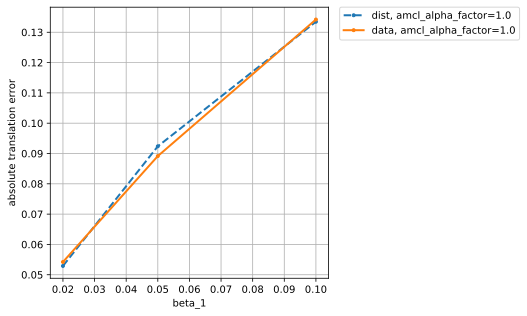

## localization: absolute_rotation_error

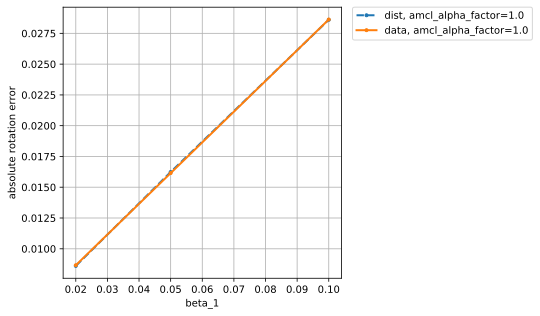

## localization: normalized_relative_translation_error

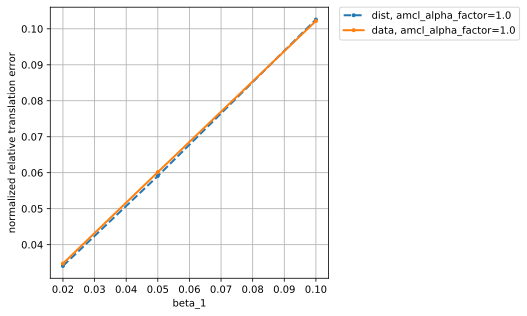

## localization: normalized_relative_rotation_error

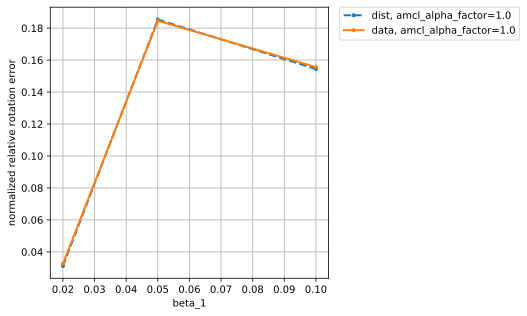

## local planner: collisionless_success_rate

### from absolute_translation_error

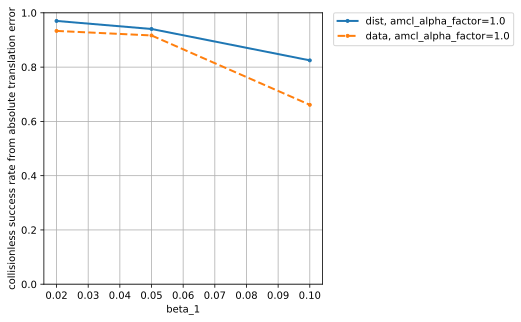

### from absolute_rotation_error

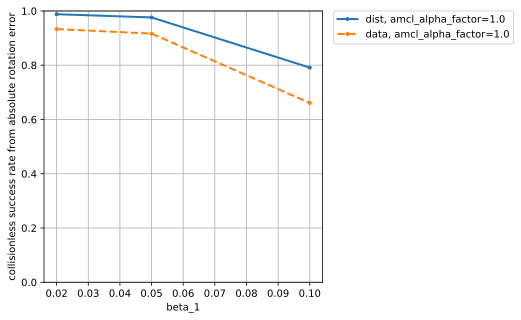

### from normalized_relative_translation_error

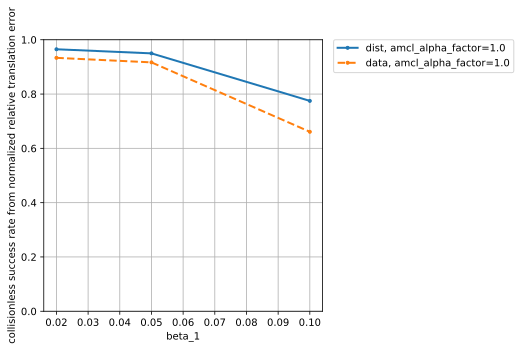

### from normalized_relative_rotation_error

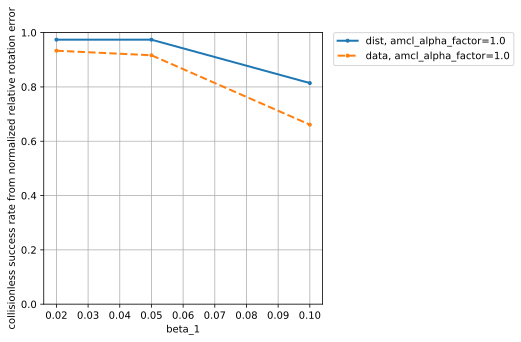

## local planner: collision_rate

### from absolute_translation_error

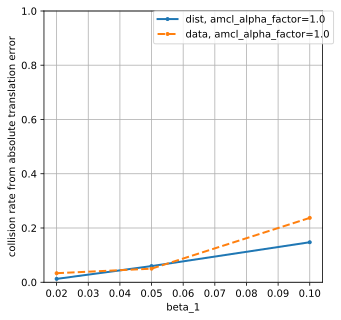

### from absolute_rotation_error

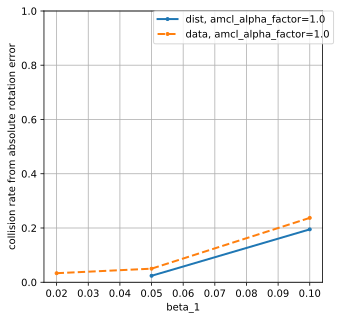

### from normalized_relative_translation_error

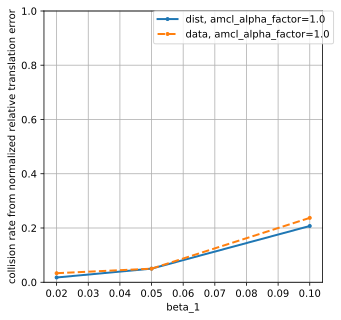

### from normalized_relative_rotation_error

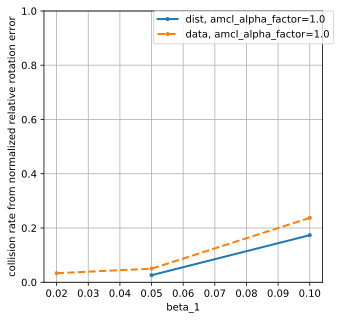

## local planner: norm_trajectory_length

### from absolute_translation_error

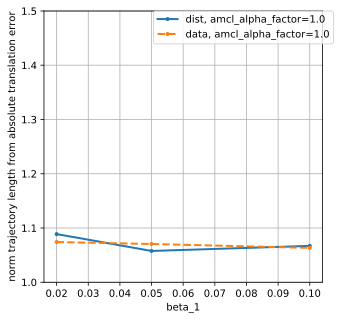

### from absolute_rotation_error

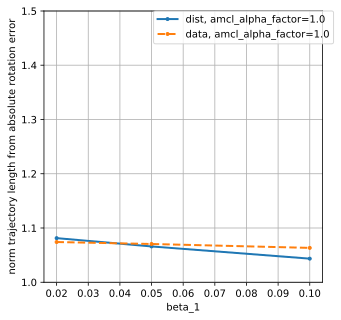

### from normalized_relative_translation_error

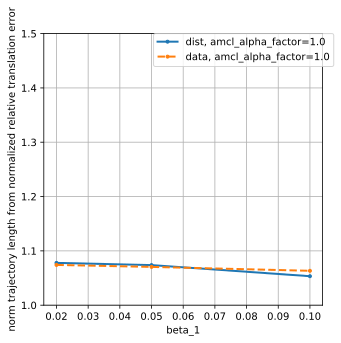

### from normalized_relative_rotation_error

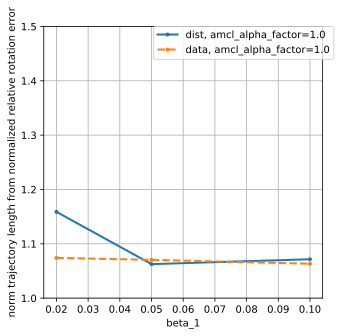

## local planner: norm_execution_time

### from absolute_translation_error

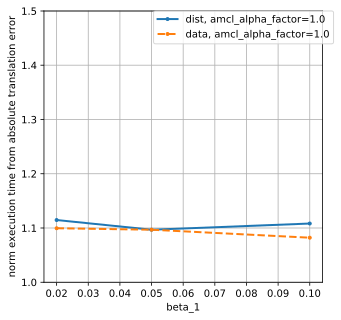

### from absolute_rotation_error

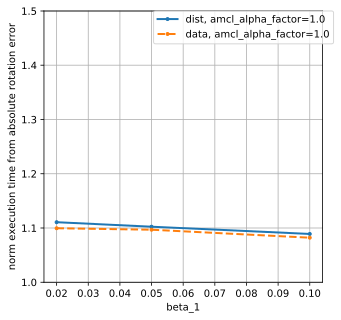

### from normalized_relative_translation_error

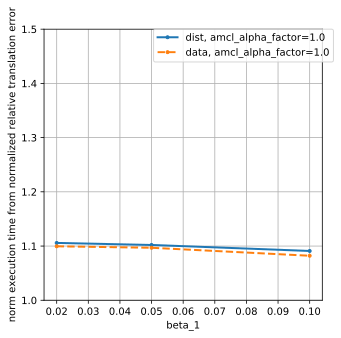

### from normalized_relative_rotation_error

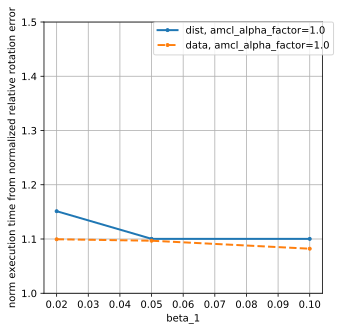

In [17]:

localization_performance = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]
local_planner_performance_all = [
    'collisionless_success_rate',
    'collision_rate',
]
local_planner_performance_success = [
    'norm_trajectory_length',
    'norm_execution_time',
]

amcl_alpha_factor_values = [1.0]
# amcl_alpha_factor_values = [0.5, 1.0, 2.0]
beta_1_values = [0.02, 0.05, 0.1]

d_fixed = df[
    (df.max_steering_angle_deg == 90.) &
    (df.robot_model == 'turtle') &
    (df.global_planner_node == 'navfn') &
    (df.localization_node == 'amcl') &
    (df.local_planner_node == 'teb')].copy()

for localization_performance_name in localization_performance:
    printmd(f"## localization: {localization_performance_name}")
    fig = plt.figure()
    for amcl_alpha_factor in amcl_alpha_factor_values:
        beta_1_y_dist = list()
        beta_1_y_data = list()
        for beta_1 in beta_1_values:
            d_all = d_fixed[(d_fixed.amcl_alpha_factor == amcl_alpha_factor) & (d_fixed.beta_1 == beta_1)].copy()
            d_localization = d_all[d_all.run_index.isin(split_localization)]
            dist = df_to_distribution(output_name=localization_performance_name, d=d_localization)
            mean = distribution_mean(dist)
            beta_1_y_dist.append(mean)
            beta_1_y_data.append(d_localization[localization_performance_name].mean())
        plt.plot(beta_1_values, beta_1_y_dist, '.--', label=f"dist, amcl_alpha_factor={amcl_alpha_factor}")
        plt.plot(beta_1_values, beta_1_y_data, '.-', label=f"data, amcl_alpha_factor={amcl_alpha_factor}")

    plt.grid()
    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.xlabel("beta_1")
    plt.ylabel(localization_performance_name.replace('_', ' '))
#     plt.ylim([min_y, max_y])
    fig.set_size_inches([5, 5])
    plt.show()


for local_planner_performance_name in local_planner_performance_all:
    printmd(f"## local planner: {local_planner_performance_name}")
    for localization_performance_name in localization_performance:
        printmd(f"### from {localization_performance_name}")
        fig = plt.figure()
        for amcl_alpha_factor in amcl_alpha_factor_values:
            beta_1_y_dist = list()
            beta_1_y_data = list()
            for beta_1 in beta_1_values:

                d_all = d_fixed[(d_fixed.amcl_alpha_factor == amcl_alpha_factor) & (d_fixed.beta_1 == beta_1)].copy()
                d_localization = d_all[d_all.run_index.isin(split_localization)]
                d_local_planner_all = d_all[d_all.run_index.isin(split_local_planner)]
                d_gt_all = d_all[d_all.run_index.isin(split_ground_truth)]
                
                dist_localization = df_to_distribution(output_name=localization_performance_name, d=d_localization)
                dist = distribution_to_distribution(
                    output_name=local_planner_performance_name,
                    input_name=localization_performance_name,
                    input_distribution=dist_localization,
                    d=d_local_planner_all
                )
                mean = distribution_mean(dist)
                beta_1_y_dist.append(mean)
                beta_1_y_data.append(d_gt_all[local_planner_performance_name].mean())
            plt.plot(beta_1_values, beta_1_y_dist, '.-', label=f"dist, amcl_alpha_factor={amcl_alpha_factor}")
            plt.plot(beta_1_values, beta_1_y_data, '.--', label=f"data, amcl_alpha_factor={amcl_alpha_factor}")

        plt.grid()
        plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.xlabel("beta_1")
        plt.ylabel(f"{local_planner_performance_name.replace('_', ' ')} from {localization_performance_name.replace('_', ' ')}")
        plt.ylim([0, 1])
        fig.set_size_inches([5, 5])
        plt.show()

for local_planner_performance_name in local_planner_performance_success:
    printmd(f"## local planner: {local_planner_performance_name}")
    for localization_performance_name in localization_performance:
        printmd(f"### from {localization_performance_name}")
        fig = plt.figure()
        for amcl_alpha_factor in amcl_alpha_factor_values:
            beta_1_y_dist = list()
            beta_1_y_data = list()
            for beta_1 in beta_1_values:

                d_all = d_fixed[(d_fixed.amcl_alpha_factor == amcl_alpha_factor) & (d_fixed.beta_1 == beta_1)].copy()
                d_success = d_fixed[(d_fixed.collisionless_success_rate == 1) & (d_fixed.amcl_alpha_factor == amcl_alpha_factor) & (d_fixed.beta_1 == beta_1)].copy()
                d_localization = d_all[d_all.run_index.isin(split_localization)]
                d_local_planner_success = d_success[d_success.run_index.isin(split_local_planner)]
                d_gt_success = d_success[d_success.run_index.isin(split_ground_truth)]
                
                dist_localization = df_to_distribution(output_name=localization_performance_name, d=d_localization)
                dist = distribution_to_distribution(
                    output_name=local_planner_performance_name,
                    input_name=localization_performance_name,
                    input_distribution=dist_localization,
                    d=d_local_planner_success
                )
                mean = distribution_mean(dist)
                beta_1_y_dist.append(mean)
                beta_1_y_data.append(d_gt_success[local_planner_performance_name].mean())
            plt.plot(beta_1_values, beta_1_y_dist, '.-', label=f"dist, amcl_alpha_factor={amcl_alpha_factor}")
            plt.plot(beta_1_values, beta_1_y_data, '.--', label=f"data, amcl_alpha_factor={amcl_alpha_factor}")

        plt.grid()
        plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.xlabel("beta_1")
        plt.ylabel(f"{local_planner_performance_name.replace('_', ' ')} from {localization_performance_name.replace('_', ' ')}")
        plt.ylim([1.0, 1.5])
        fig.set_size_inches([5, 5])
        plt.show()


In [ ]:

def from_constraints(amcl_alpha_factor, beta_1):
    d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor == amcl_alpha_factor) & (df.beta_1 == beta_1)].copy()
    d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor == amcl_alpha_factor) & (df.beta_1 == beta_1)].copy()

    localization_performance_dists = dict()
    for localization_performance_name in localization_performance:
        localization_performance_dists[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_all)

    local_planner_aio_dists = dict()
    local_planner_composed_dists = defaultdict(dict)
    for local_planner_performance_name in local_planner_performance_all:
        local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_all)
        for localization_performance_name in localization_performance:
            local_planner_composed_dists[localization_performance_name][local_planner_performance_name] = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_all)

    for local_planner_performance_name in local_planner_performance_success:
        local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_success)
        for localization_performance_name in localization_performance:
            local_planner_composed_dists[localization_performance_name][local_planner_performance_name] = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_success)
    
    return localization_performance_dists, local_planner_aio_dists, local_planner_composed_dists

localization_performance_dists_1, local_planner_aio_dists_1, local_planner_composed_dists_1 = from_constraints(amcl_alpha_factor=2.0, beta_1=0.02)
localization_performance_dists_2, local_planner_aio_dists_2, local_planner_composed_dists_2 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.02)
localization_performance_dists_3, local_planner_aio_dists_3, local_planner_composed_dists_3 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.05)
localization_performance_dists_4, local_planner_aio_dists_4, local_planner_composed_dists_4 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.1)

plot_distribution(
    output_name='absolute_translation_error',
    distribution_1=localization_performance_dists_1['absolute_translation_error'],
    label_1='alpha_factor=2.0, beta_1=0.02',
    distribution_2=localization_performance_dists_2['absolute_translation_error'],
    label_2='alpha_factor=1.0, beta_1=0.02'
)
plot_distribution(
    output_name='absolute_translation_error',
    distribution_1=localization_performance_dists_2['absolute_translation_error'],
    label_1='alpha_factor=1.0, beta_1=0.02',
    distribution_2=localization_performance_dists_3['absolute_translation_error'],
    label_2='alpha_factor=1.0, beta_1=0.05'
)
plot_distribution(
    output_name='absolute_translation_error',
    distribution_1=localization_performance_dists_2['absolute_translation_error'],
    label_1='alpha_factor=1.0, beta_1=0.02',
    distribution_2=localization_performance_dists_4['absolute_translation_error'],
    label_2='alpha_factor=1.0, beta_1=0.1'
)


In [ ]:

def from_constraints(amcl_alpha_factor, beta_1):
    d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor == amcl_alpha_factor) & (df.beta_1 == beta_1)].copy()
    d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor == amcl_alpha_factor) & (df.beta_1 == beta_1)].copy()

    localization_performance_dists = dict()
    for localization_performance_name in localization_performance:
        localization_performance_dists[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_all)

    local_planner_aio_dists = dict()
    local_planner_composed_dists = defaultdict(dict)
    for local_planner_performance_name in local_planner_performance_all:
        local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_all)
        for localization_performance_name in localization_performance:
            local_planner_composed_dists[localization_performance_name][local_planner_performance_name] = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_all)

    for local_planner_performance_name in local_planner_performance_success:
        local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_success)
        for localization_performance_name in localization_performance:
            local_planner_composed_dists[localization_performance_name][local_planner_performance_name] = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_success)
    
    return localization_performance_dists, local_planner_aio_dists, local_planner_composed_dists

localization_performance_dists_1, local_planner_aio_dists_1, local_planner_composed_dists_1 = from_constraints(amcl_alpha_factor=1.5, beta_1=0.02)
localization_performance_dists_2, local_planner_aio_dists_2, local_planner_composed_dists_2 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.02)
localization_performance_dists_3, local_planner_aio_dists_3, local_planner_composed_dists_3 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.05)
localization_performance_dists_4, local_planner_aio_dists_4, local_planner_composed_dists_4 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.1)

printmd("## alpha_factor = 1.5 → 1.0")
plot_distribution(
    output_name='collision_rate',
    distribution_1=local_planner_composed_dists_1['absolute_rotation_error']['collision_rate'],
    label_1='alpha_factor=1.5, beta_1=0.02',
    distribution_2=local_planner_composed_dists_2['absolute_rotation_error']['collision_rate'],
    label_2='alpha_factor=1.0, beta_1=0.02'
)
printmd("## beta_1 = 0.02 → 0.05")
plot_distribution(
    output_name='collision_rate',
    distribution_1=local_planner_composed_dists_2['absolute_rotation_error']['collision_rate'],
    label_1='alpha_factor=1.0, beta_1=0.02',
    distribution_2=local_planner_composed_dists_3['absolute_rotation_error']['collision_rate'],
    label_2='alpha_factor=1.0, beta_1=0.05'
)
printmd("## beta_1 = 0.02 → 0.1")
plot_distribution(
    output_name='collision_rate',
    distribution_1=local_planner_composed_dists_2['absolute_rotation_error']['collision_rate'],
    label_1='alpha_factor=1.0, beta_1=0.02',
    distribution_2=local_planner_composed_dists_4['absolute_rotation_error']['collision_rate'],
    label_2='alpha_factor=1.0, beta_1=0.1'
)


In [ ]:

def from_constraints(amcl_alpha_factor, beta_1):
    d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor == amcl_alpha_factor) & (df.beta_1 == beta_1)].copy()
    d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor == amcl_alpha_factor) & (df.beta_1 == beta_1)].copy()

    localization_performance_dists = dict()
    for localization_performance_name in localization_performance:
        localization_performance_dists[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_all)

    local_planner_aio_dists = dict()
    local_planner_composed_dists = defaultdict(dict)
    for local_planner_performance_name in local_planner_performance_all:
        local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_all)
        for localization_performance_name in localization_performance:
            local_planner_composed_dists[localization_performance_name][local_planner_performance_name] = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_all)

    for local_planner_performance_name in local_planner_performance_success:
        local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_success)
        for localization_performance_name in localization_performance:
            local_planner_composed_dists[localization_performance_name][local_planner_performance_name] = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_success)
    
    return localization_performance_dists, local_planner_aio_dists, local_planner_composed_dists

localization_performance_dists_1, local_planner_aio_dists_1, local_planner_composed_dists_1 = from_constraints(amcl_alpha_factor=1.5, beta_1=0.02)
localization_performance_dists_2, local_planner_aio_dists_2, local_planner_composed_dists_2 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.02)
localization_performance_dists_3, local_planner_aio_dists_3, local_planner_composed_dists_3 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.05)
localization_performance_dists_4, local_planner_aio_dists_4, local_planner_composed_dists_4 = from_constraints(amcl_alpha_factor=1.0, beta_1=0.1)

printmd("## alpha_factor = 1.5 → 1.0")
plot_distribution(
    output_name='norm_trajectory_length',
    distribution_1=local_planner_composed_dists_1['absolute_translation_error']['norm_trajectory_length'],
    label_1='alpha_factor=1.5, beta_1=0.02',
    distribution_2=local_planner_composed_dists_2['absolute_translation_error']['norm_trajectory_length'],
    label_2='alpha_factor=1.0, beta_1=0.02'
)
printmd("## beta_1 = 0.02 → 0.05")
plot_distribution(
    output_name='norm_trajectory_length',
    distribution_1=local_planner_composed_dists_2['absolute_translation_error']['norm_trajectory_length'],
    label_1='alpha_factor=1.0, beta_1=0.02',
    distribution_2=local_planner_composed_dists_3['absolute_translation_error']['norm_trajectory_length'],
    label_2='alpha_factor=1.0, beta_1=0.05'
)
printmd("## beta_1 = 0.02 → 0.1")
plot_distribution(
    output_name='norm_trajectory_length',
    distribution_1=local_planner_composed_dists_2['absolute_translation_error']['norm_trajectory_length'],
    label_1='alpha_factor=1.0, beta_1=0.02',
    distribution_2=local_planner_composed_dists_4['absolute_translation_error']['norm_trajectory_length'],
    label_2='alpha_factor=1.0, beta_1=0.1'
)


In [ ]:

# localization_performance = [
#     'absolute_translation_error',
#     'absolute_rotation_error',
#     'normalized_relative_translation_error',
#     'normalized_relative_rotation_error',
# ]
# local_planner_performance_all = [
#     'collisionless_success_rate',
#     'collision_rate',
# ]
# local_planner_performance_success = [
#     'norm_trajectory_length',
#     'norm_execution_time',
# ]

# amcl_alpha_factor = 1.0
# # beta_1_1 = 0.02
# beta_1_2 = 0.05

# # d_all_1 = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_all.amcl_alpha_factor_d == amcl_alpha_factor) & (d_all.beta_1_d == beta_1_1)].copy()
# d_all_2 = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_all.amcl_alpha_factor_d == amcl_alpha_factor) & (d_all.beta_1_d == beta_1_2)].copy()
# # d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_all.amcl_alpha_factor_d == amcl_alpha_factor) & (d_all.beta_1_d == beta_1_1)].copy()
# d_success_2 = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_all.amcl_alpha_factor_d == amcl_alpha_factor) & (d_all.beta_1_d == beta_1_2)].copy()


# localization_performance_dists = dict()
# local_planner_aio_dists_2 = dict()
# local_planner_composed_dists_2 = defaultdict(dict)
# for localization_performance_name in localization_performance:
#     printmd(f"## localization performance: {localization_performance_name}")
#     localization_performance_dists[localization_performance_name] = df_to_distribution(output_name=localization_performance_name, d=d_all)
#     plot_distribution(output_name=localization_performance_name, distribution_1=localization_performance_dists[localization_performance_name])

# for local_planner_performance_name in local_planner_performance_all:
#     printmd(f"## local planner performance: {local_planner_performance_name}")
#     local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_all)
#     for localization_performance_name in localization_performance:
#         printmd(f"### from {localization_performance_name}")
#         dist_lp_d2d = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_all)
#         plot_distribution(output_name=local_planner_performance_name, distribution_1=local_planner_aio_dists[local_planner_performance_name], label_1='all in one', distribution_2=dist_lp_d2d, label_2='composed')

# for local_planner_performance_name in local_planner_performance_success:
#     printmd(f"## local planner performance: {local_planner_performance_name}")
#     local_planner_aio_dists[local_planner_performance_name] = df_to_distribution(output_name=local_planner_performance_name, d=d_success)
#     for localization_performance_name in localization_performance:
#         printmd(f"### from {localization_performance_name}")
#         dist_lp_d2d = distribution_to_distribution(output_name=local_planner_performance_name, input_name=localization_performance_name, input_distribution=localization_performance_dists[localization_performance_name], d=d_success)
#         plot_distribution(output_name=local_planner_performance_name, distribution_1=local_planner_aio_dists[local_planner_performance_name], label_1='all in one', distribution_2=dist_lp_d2d, label_2='composed')

In [ ]:

# localization_output = [
#     'absolute_translation_error',
#     'absolute_rotation_error',
#     'normalized_relative_translation_error',
#     'normalized_relative_rotation_error',
# ]
# local_planner_output_all = [
#     'collisionless_success_rate',
#     'collision_rate',
# ]
# local_planner_output_success = [
#     'norm_trajectory_length',
#     'norm_execution_time',
# ]

# amcl_alpha_factor = 1.0
# beta_1 = 0.02

# printmd("### in:")
# d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_all.amcl_alpha_factor_d == 1.0) & (d_all.beta_1_d == 0.02)].copy()
# print(f"num datapoints: {len(d_all)}")
# for input_name in ['amcl_alpha_factor', 'beta_1']:
#     hist_out(d_all, input_name)

# printmd("### out localization (all):")
# d_out_localization_all = d_all
# print(f"num datapoints: {len(d_out_localization_all)}")
# for output_name in localization_output:
#     hist_out(d_out_localization_all, output_name)

# printmd("### out local planner (all):")
# d_out_local_planner_all = d_all
# print(f"num datapoints: {len(d_out_local_planner_all)}")
# for output_name in local_planner_output_all:
#     hist_out(d_out_local_planner_all, output_name)

# d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (d_success.amcl_alpha_factor_d == 1.0) & (d_success.beta_1_d == 0.02)].copy()
# printmd("### out local planner (success):")
# d_out_local_planner_success = d_success
# print(f"num datapoints: {len(d_out_local_planner_success)}")
# for output_name in local_planner_output_success:
#     hist_out(d_out_local_planner_success, output_name)


In [ ]:

# localization_output = [
#     'absolute_translation_error',
#     'absolute_rotation_error',
#     'normalized_relative_translation_error',
#     'normalized_relative_rotation_error',
# ]
# local_planner_output_all = [
#     'collisionless_success_rate',
#     'collision_rate',
# ]
# local_planner_output_success = [
#     'norm_trajectory_length',
#     'norm_execution_time',
# ]

# amcl_alpha_factor = 1.0
# beta_1 = 0.02

# printmd("### in:")
# d_all = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# print(f"num datapoints: {len(d_all)}")

# printmd("### out localization (all):")
# d_out_localization_all = d_all[(d_all.amcl_alpha_factor_d == 1.0) & (d_all.beta_1_d == 0.02)]
# print(f"num datapoints: {len(d_out_localization_all)}")
# for output_name in localization_output:
#     hist_out(d_out_localization_all, output_name)

# printmd("### out local planner (all):")
# d_out_local_planner_all = d_all[(d_all.amcl_alpha_factor_d == 1.0) & (d_all.beta_1_d == 0.02)]
# print(f"num datapoints: {len(d_out_local_planner_all)}")
# for output_name in local_planner_output_all:
#     hist_out(d_out_local_planner_all, output_name)

# d_success = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# printmd("### out local planner (success):")
# d_out_local_planner_success = d_success[(d_success.amcl_alpha_factor_d == 1.0) & (d_success.beta_1_d == 0.02)]
# print(f"num datapoints: {len(d_out_local_planner_success)}")
# for output_name in local_planner_output_success:
#     hist_out(d_out_local_planner_success, output_name)
